## 1. Data Overview
Refer to the competition page for details: https://www.kaggle.com/c/humpback-whale-identification/data

## 2. Dependencies

In [1]:
# Install tf 2.0
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 46.0MB/s 
     |████████████████████████████████| 450kB 44.0MB/s 
     |████████████████████████████████| 3.8MB 31.3MB/s 
     |████████████████████████████████| 71kB 22.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=23d3243c66f40d84a9300cb94c7d8cd83527d15b5ea3684abefae1cd8ff3a7ae
  Stored in directory: /tmp/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for opt-einsum: filename=opt_einsum-3.1.0-cp36-none-any.whl size=61682 sha256=59a48656f2be5c9c62ab9337ff74c52b0b4ddabc5d02fa80fe7886702c04707a
  Stored in directory: /tmp/.cache/pip/wheels/2c/b1/94/43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
Successfully built gast opt-einsum
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Found existing installation: gast 0.3.2
    Uninstalling g

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf

from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPool2D,Concatenate,concatenate,Lambda, Flatten, Dense, BatchNormalization, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import os

In [3]:
tf.__version__

'2.0.0'

## 3. Parameters

In [4]:
# Hyperparameters
batch_size = 32
epochs = 10
img_height = 128
img_width = 128
val_split = 0.1
AUTOTUNE = tf.data.experimental.AUTOTUNE
val_size = np.floor(batch_size*val_split)
num_predict_img = 10

## 4. Prepare Data for Model

In [5]:
# Load file-labels data
train_dir = '../input/humpback-whale-identification/train/'
test_dir = '../input/humpback-whale-identification/test/'
df = pd.read_csv('../input/humpback-whale-identification/train.csv')

# Get the classes with more than 10 images
df_classesCount = df.groupby('Id').count().sort_values('Image',ascending=False)
class_names = df_classesCount[df_classesCount['Image']>10]
class_names = class_names.index
num_classes = len(class_names)
print('Number of classes:',num_classes)

# Get test image file names
list_test = os.listdir(test_dir)

Number of classes: 228


In [6]:
# Helper functions
def getDFBatch(batch_size=32):
    """Create dataframe with pairs of image files, where half same class with target 1 
    and half different classes with target 0"""
    image_pairs = [[],[]]
    targets = [1]*(batch_size//2)+[0]*(batch_size//2)
    for i in range(batch_size//2):
        # Choose one class
        target = np.random.choice(class_names,replace=False)
        # Choose two image files from the same class
        image_pair = np.random.choice(df[df['Id']==target]['Image'],2,replace=False)
        image_pairs[0].insert(0,image_pair[0])
        image_pairs[1].insert(0,image_pair[1])
        # Choose two classes
        target = np.random.choice(class_names,2,replace=False)
        # Choose two image files from different classes
        im1 = np.random.choice(df[df['Id']==target[0]]['Image'],replace=False)
        im2 = np.random.choice(df[df['Id']==target[1]]['Image'],replace=False)
        image_pairs[0].append(im1)
        image_pairs[1].append(im2)
    return pd.DataFrame({'left_image':image_pairs[0],'right_image':image_pairs[1],'targets':targets})

    
def processDS(left_file,right_file,target):
    """Process on training dataset elements to get the images and target"""
    # Read images
    left_file_path=train_dir+left_file
    right_file_path=train_dir+right_file
    img_left = tf.io.read_file(left_file_path)
    img_right = tf.io.read_file(right_file_path)
    
    # Convert to grayscale
    img_left = tf.image.decode_jpeg(img_left, channels=1)
    img_right = tf.image.decode_jpeg(img_right, channels=1)
    # Convert to floats in the [0,1] range.
    img_left = tf.image.convert_image_dtype(img_left, tf.float32)
    img_right = tf.image.convert_image_dtype(img_right, tf.float32)
    # Resize the image to the desired size.
    img_left = tf.image.resize(img_left, [img_width, img_height])
    img_right = tf.image.resize(img_right, [img_width, img_height])
    
    return [img_left,img_right],target

def processTestDS(left_file,right_file):
    """Process on testing dataset elements to get the images"""
    # Read images
    left_file_path=train_dir+left_file
    right_file_path=test_dir+right_file
    img_left = tf.io.read_file(left_file_path)
    img_right = tf.io.read_file(right_file_path)
    
    # Convert to grayscale
    img_left = tf.image.decode_jpeg(img_left, channels=1)
    img_right = tf.image.decode_jpeg(img_right, channels=1)
    # Convert to floats in the [0,1] range.
    img_left = tf.image.convert_image_dtype(img_left, tf.float32)
    img_right = tf.image.convert_image_dtype(img_right, tf.float32)
    # Resize the image to the desired size.
    img_left = tf.image.resize(img_left, [img_width, img_height])
    img_right = tf.image.resize(img_right, [img_width, img_height])
    
    images = [img_left,img_right]
    images = tf.reshape(images, (2,img_height,img_width,1))
    
    return images

def getBatch(batch_size=32,df_img_files=None):
    """Create a dataset for training/testing data"""
    df_batch = getDFBatch(batch_size=batch_size)
    
    if df_img_files is None:
        ds = tf.data.Dataset.from_tensor_slices((df_batch['left_image'].values,df_batch['right_image'].values,\
                                             df_batch['targets'].values))
        labeled_ds = ds.map(processDS, num_parallel_calls=AUTOTUNE)
        return labeled_ds
    else:
        ds = tf.data.Dataset.from_tensor_slices((df_img_files['left_image'].values,\
                                                 df_img_files['right_image'].values))
        labeled_ds = ds.map(processTestDS, num_parallel_calls=AUTOTUNE)
        return labeled_ds


## 5. Siamese NN Model

We will implement an Siamese NN in Tensorflow 2.0. Reference http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf

In [7]:
# Helper functions
def siameseModel(input_shape):
    # Define the tensors for the two input images
    inputs = Input(([2]+input_shape))
    left_input = inputs[:,0,:,:,:]
    right_input = inputs[:,1,:,:,:]
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
    model.add(MaxPool2D())
    model.add(Conv2D(128, (7,7), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(MaxPool2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(MaxPool2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='sigmoid', kernel_regularizer=l2(1e-3)))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:tf.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=inputs,outputs=prediction)
      
    # Compile model
    siamese_net.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    siamese_net.summary()
    
    # return the model
    return siamese_net



In [8]:
# Build model
model=siameseModel([img_height,img_width,1])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 128, 128, 0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 128, 128, 1) 0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 128, 128, 1) 0           input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 228)          4930596     tf_op_layer_strided_slice[0][0]  
                                                                 tf_op_layer_strided_slice_1[0

In [9]:
# Train model
history = []
for i in range(epochs):
    train_batch = getBatch(batch_size)
    train_batch = train_batch.shuffle(batch_size)
    # create validation dataset
    valid_ds = train_batch.take(val_size)
    valid_ds = valid_ds.batch(val_size)
    # create training dataset
    train_ds = train_batch.skip(val_size)
    train_ds = train_ds.batch(batch_size-val_size)
    
    train_hist = model.train_on_batch(train_ds)
    val_hist = model.test_on_batch(valid_ds)
    history.append([train_hist, val_hist])
    
    if i%2==0:
        print('Epoch {} ------------'.format(i))
        print('Training loss and accuracy')
        print(train_hist)
        print('Validation loss and accuracy')
        print(val_hist)
    

Epoch 0 ------------
Training loss and accuracy
[1.2197762, 0.51724136]
Validation loss and accuracy
[1.1590034, 0.6666667]
Epoch 2 ------------
Training loss and accuracy
[1.1318283, 0.51724136]
Validation loss and accuracy
[1.0214996, 0.6666667]
Epoch 4 ------------
Training loss and accuracy
[1.0587934, 0.55172414]
Validation loss and accuracy
[1.0029497, 0.6666667]
Epoch 6 ------------
Training loss and accuracy
[1.0624392, 0.41379312]
Validation loss and accuracy
[1.0714192, 0.0]
Epoch 8 ------------
Training loss and accuracy
[0.96501887, 0.55172414]
Validation loss and accuracy
[0.9328128, 0.6666667]


In [10]:
# Predict

# prepare test data
idx = np.random.randint(len(df), size=num_predict_img)
new_df = df.iloc[idx]
test_classes = new_df['Id']
new_df = new_df.drop(columns='Id')
new_df['right_image']=list_test[0]
new_df.rename(columns={'Image': 'left_image'}, inplace=True)
test_batch=getBatch(df_img_files=new_df)
test_batch=test_batch.batch(num_predict_img)

# Get the scores
r=model.predict(test_batch)
print(r)

# Get the best class matching
best_idx = np.argmax(r.reshape(-1))
print('Best match is: ', test_classes.iloc[best_idx])

[[0.48840216]
 [0.49143553]
 [0.4706464 ]
 [0.46081746]
 [0.45783985]
 [0.46294454]
 [0.4724874 ]
 [0.4616399 ]
 [0.47988793]
 [0.47252703]]
Best match is:  new_whale


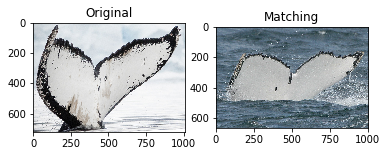

In [11]:
# Visualize the best matching
best_img_file = new_df['left_image'].iloc[best_idx]
plt.subplot(1,2,1)
img = mpimg.imread(test_dir+list_test[0])
plt.imshow(img)
plt.title('Original')
plt.subplot(1,2,2)
img = mpimg.imread(train_dir+best_img_file)
plt.imshow(img)
plt.title('Matching')
plt.show()